# Packages

In [1]:
# libraries
import time
import functools
from numpy.polynomial.laguerre import lagval
from numpy.polynomial.chebyshev import chebval
from numpy.polynomial.hermite import hermval
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.qmc import Sobol
from scipy.stats import norm
import numpy as np
from typing import Callable, Sequence, Tuple, List, Any, Dict, Mapping
import sympy
sympy.init_printing()

np.random.seed(2025)


# Parameter

The parameters are replicated from Longstaff and Schwartz (2001). One could argue that the riskfree rate at 6% is high in todays economy. Lowering the rf would increase the price of the option due to it being discounted less. We still choose to use 6% as we are trying to replicate Longstaff and Schwartz. 

In [2]:
spot_price = 40
strike = 40
expiry = 1.0
rf = 0.06
sigma = 0.2
n_steps = 50
dt =expiry / n_steps
num_paths = 10000
lognormal = True
is_call = False

In [3]:
def vanilla_american_payoff(_: float, x: np.ndarray) -> float:
    S = x[-1] 
    if is_call:
        return max(S - 1, 0.0)
    else:
        return max(1 - S, 0.0)


## Define Polynomials

These polynomials are mainly being defined to understand what is happening as numpy will be used in the code

In [4]:
def laguerre_polynomials(x, degree):
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return 1 - x
    elif degree == 2:
        return (1 - 2*x + x**2) / 2
    elif degree == 3:
        return (1 - 3*x + 3*x**2 - x**3) / 6
    elif degree == 4:
        return (1 - 4*x + 6*x**2 - 4*x**3 + x**4) / 24
    elif degree == 5:
        return (1 - 5*x + 10*x**2 - 10*x**3 + 5*x**4 - x**5) / 120
    return np.ones_like(x)

def chebyshev_polynomials(x, degree):
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return x
    elif degree == 2:
        return 2 * x**2 - 1
    elif degree == 3:
        return 4 * x**3 - 3 * x
    elif degree == 4:
        return 8 * x**4 - 8 * x**2 + 1
    elif degree == 5:
        return 16 * x**5 - 20 * x**3 + 5 * x
    return np.ones_like(x)

def hermite_polynomials(x, degree):
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return 2 * x
    elif degree == 2:
        return 4 * x**2 - 2
    elif degree == 3:
        return 8 * x**3 - 12 * x
    elif degree == 4:
        return 16 * x**4 - 48 * x**2 + 12
    elif degree == 5:
        return 32 * x**5 - 160 * x**3 + 120 * x
    return np.ones_like(x)


## Simulating paths

We simulate paths using Geometric Brownian Motion with antithetic variates, a common variance reduction technique in Monte Carlo methods. These paths are used as input to the LSM pricing algorithm.


In [5]:
# Parameters from Longstaff-Schwartz
num_paths = 50_000
dt = expiry / n_steps

# Generate standard normal shocks (with antithetic variates)
Z = np.random.normal(size=(num_paths, n_steps))
Z_antithetic = -Z
Z_full = np.concatenate([Z, Z_antithetic], axis=0)

# Calculate log returns and construct paths
log_returns = (rf - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_full
log_paths = np.cumsum(log_returns, axis=1)
log_paths = np.concatenate([np.zeros((2 * num_paths, 1)), log_paths], axis=1)
paths = spot_price * np.exp(log_paths)
paths = paths / strike 


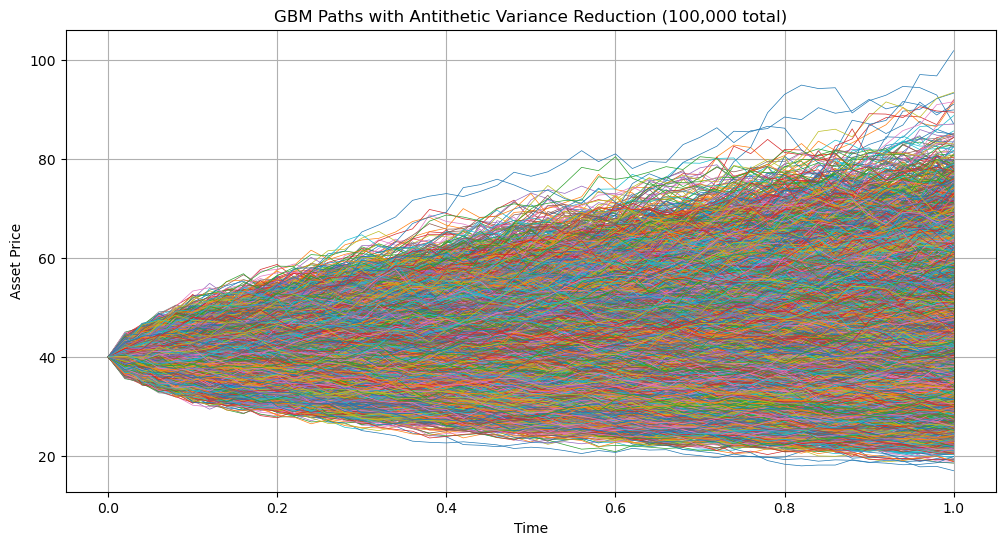

In [6]:
plt.figure(figsize=(12, 6))
for i in range(100000):
    plt.plot(np.linspace(0, expiry, n_steps + 1), paths[i] * strike, linewidth=0.5)
plt.title("GBM Paths with Antithetic Variance Reduction (100,000 total)")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()


## Pricing

The `AmericanPricer` class implements the Least-Squares Monte Carlo (LSM) algorithm for pricing American-style options, based on the method introduced by Longstaff & Schwartz (2001). The algorithm simulates multiple price paths and performs backward induction to estimate the option’s value. At each timestep, the continuation value is approximated using a linear regression on a set of user-defined feature functions. If the immediate payoff exceeds the estimated continuation value, early exercise is optimal and the cash flow is updated accordingly. The final price is computed as the discounted average of optimal cash flows across all simulated paths.

In [7]:
class AmericanPricer:
    def __init__(
        self,
        spot_price: float,
        expiry: float,
        payoff: Callable[[float, np.ndarray], float],
        r: float
    ):
        self.spot_price = spot_price
        self.expiry = expiry
        self.payoff = payoff
        self.r = r

    def _construct_state(self, t: int, price_seq: np.ndarray, remaining_steps: int) -> Dict[str, Any]:
        current_price = price_seq[-1] / strike
        return {
            't': t,
            'x': price_seq,
            'remaining_steps': remaining_steps,
            'current_price': current_price
        }

    def get_lsm_price(self, paths: np.ndarray, num_dt: int,
                      feature_funcs: Sequence[Callable[[Dict[str, Any]], float]]) -> Tuple[float, List[np.ndarray]]:
        start_time = time.time()
        dt = self.expiry / num_dt
        num_paths = paths.shape[0]
        cashflow = np.array([max(self.payoff(self.expiry, paths[i]), 0.0) for i in range(num_paths)])
        coeffs_list = [None] * num_dt
        for step in range(num_dt - 1, 0, -1):
            t = step * dt
            disc = np.exp(-self.r * dt)
            cashflow *= disc
            payoffs_step = np.array([self.payoff(t, paths[i, : step+1]) for i in range(num_paths)])
            in_the_money = payoffs_step > 0

            if np.any(in_the_money):
                X_list, Y_list = [], []
                for i, itm in enumerate(in_the_money):
                    if itm:
                        state = self._construct_state(step, paths[i, : step+1], num_dt - step)
                        feats = [f(state) for f in feature_funcs]
                        X_list.append(feats)
                        Y_list.append(cashflow[i])

                X = np.array(X_list)
                Y = np.array(Y_list)
                coeffs = np.linalg.lstsq(X, Y, rcond=None)[0]
                cont_estimate = X @ coeffs
                coeffs_list[step] = coeffs

                idx = 0
                for i, itm in enumerate(in_the_money):
                    if itm:
                        if payoffs_step[i] > cont_estimate[idx]:
                            cashflow[i] = payoffs_step[i]
                        idx += 1

        lsm_price = max(
            self.payoff(0.0, np.array([self.spot_price])),
            np.mean(cashflow * np.exp(-self.r * dt))
        ) * strike

        discounted_cashflows = cashflow * np.exp(-self.r * dt)
        std_error = np.std(discounted_cashflows) / np.sqrt(num_paths)

        print(f"LSM took {time.time() - start_time:.2f} seconds.")
        return lsm_price, coeffs_list, std_error

This section evaluates the impact of different polynomial basis functions: Laguerre, Hermite, and Chebyshev on the pricing of American put options using the Least-Squares Monte Carlo (LSM) method. Each basis type is implemented as a set of feature functions, which depend on the normalized asset price at each exercise date. Laguerre polynomials are evaluated directly on the normalized price, Hermite polynomials use a z-score transformation, and Chebyshev polynomials are mapped to the interval [-1, 1]. For each basis, the conditional expectation (continuation value) is estimated via linear regression using the selected features.

In [17]:
def get_laguerre_feature_funcs(max_degree: int):
    return [
        lambda state, d=d: lagval(
            np.maximum(state["current_price"], 1e-8),
            [0]*d + [1]
        )
        for d in range(max_degree + 1)
    ]

def get_hermite_feature_funcs(max_degree: int, mu: float, sigma: float):
    def zscore(x): return (x - mu) / sigma
    return [
        lambda state, d=d: hermval(
            zscore(state["current_price"]),
            [0]*d + [1]
        )
        for d in range(max_degree + 1)
    ]

def get_chebyshev_feature_funcs(max_degree: int, S_min: float, S_max: float):
    def to_chebyshev_domain(x):
        return (2 * x - (S_min + S_max)) / (S_max - S_min)
    return [
        lambda state, d=d: chebval(
            to_chebyshev_domain(state["current_price"]),
            [0]*d + [1]
        )
        for d in range(max_degree + 1)
    ]

terminal_prices = paths[:, -1]
S_min = np.min(terminal_prices)
S_max = np.max(terminal_prices)
mu = np.mean(terminal_prices)
sigma = np.std(terminal_prices)

degrees = list(range(1, 6))
std_errors = { "Laguerre": [] }
laguerre_prices = []

print("=== Teoretisk korrekt sammenligning af basisfunktioner ===")
print("\nLaguerre basisfunktioner:")
for degree in degrees:
    feature_funcs = get_laguerre_feature_funcs(degree)

    pricer = AmericanPricer(
        spot_price=spot_price,
        expiry=expiry,
        payoff=vanilla_american_payoff,
        r=rf
    )

    lsm_price, _, std_error = pricer.get_lsm_price(
        paths=paths,
        num_dt=n_steps,
        feature_funcs=feature_funcs
    )

    std_errors["Laguerre"].append(std_error)
    laguerre_prices.append(lsm_price)

    print(f"Laguerre degree {degree}: price = {lsm_price:.6f}, std_error = {std_error:.6f}")

# Hermite degree 3
print("\nHermite basisfunktioner (degree 3):")
feature_funcs = get_hermite_feature_funcs(4, mu=mu, sigma=sigma)
pricer = AmericanPricer(
    spot_price=spot_price,
    expiry=expiry,
    payoff=vanilla_american_payoff,
    r=rf
)
lsm_price, _, std_error = pricer.get_lsm_price(
    paths=paths,
    num_dt=n_steps,
    feature_funcs=feature_funcs
)
print(f"Hermite degree 3: price = {lsm_price:.6f}, std_error = {std_error:.6f}")

# Chebyshev degree 3
print("\nChebyshev basisfunktioner (degree 3):")
feature_funcs = get_chebyshev_feature_funcs(4, S_min=S_min, S_max=S_max)
pricer = AmericanPricer(
    spot_price=spot_price,
    expiry=expiry,
    payoff=vanilla_american_payoff,
    r=rf
)
lsm_price, _, std_error = pricer.get_lsm_price(
    paths=paths,
    num_dt=n_steps,
    feature_funcs=feature_funcs
)
print(f"Chebyshev degree 3: price = {lsm_price:.6f}, std_error = {std_error:.6f}")


=== Teoretisk korrekt sammenligning af basisfunktioner ===

Laguerre basisfunktioner:
LSM took 17.23 seconds.
Laguerre degree 1: price = 2.277449, std_error = 0.000229
LSM took 24.55 seconds.
Laguerre degree 2: price = 2.311478, std_error = 0.000218
LSM took 33.56 seconds.
Laguerre degree 3: price = 2.321277, std_error = 0.000217
LSM took 42.54 seconds.
Laguerre degree 4: price = 2.320722, std_error = 0.000217
LSM took 52.61 seconds.
Laguerre degree 5: price = 2.321556, std_error = 0.000217

Hermite basisfunktioner (degree 3):
LSM took 33.13 seconds.
Hermite degree 3: price = 2.317713, std_error = 0.000214

Chebyshev basisfunktioner (degree 3):
LSM took 32.72 seconds.
Chebyshev degree 3: price = 2.320905, std_error = 0.000217


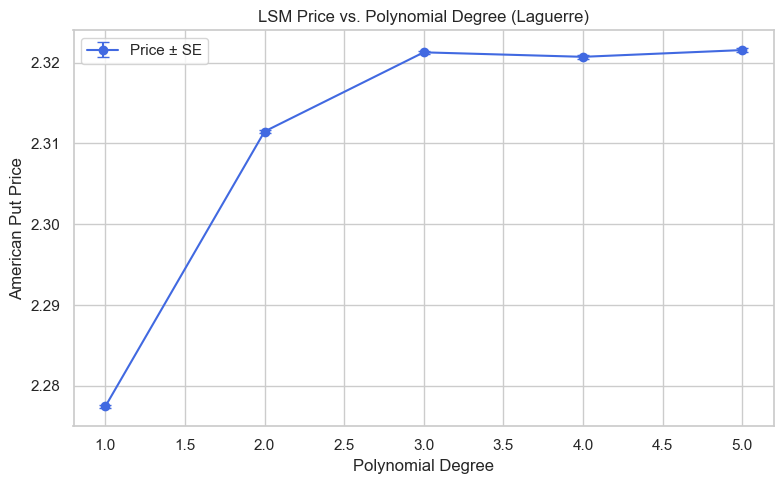

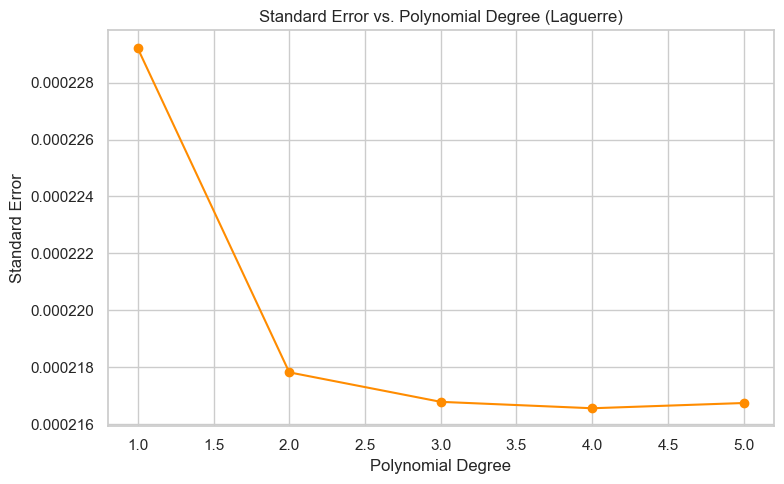

LSM took 131.84 seconds.
LSM took 65.80 seconds.
LSM took 33.35 seconds.
LSM took 16.75 seconds.
LSM took 6.50 seconds.


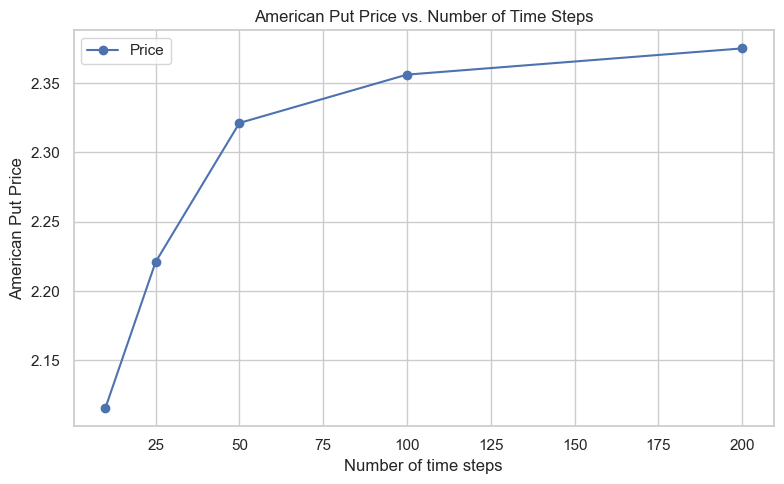

LSM took 3.34 seconds.
LSM took 9.99 seconds.
LSM took 16.51 seconds.
LSM took 26.60 seconds.
LSM took 33.09 seconds.


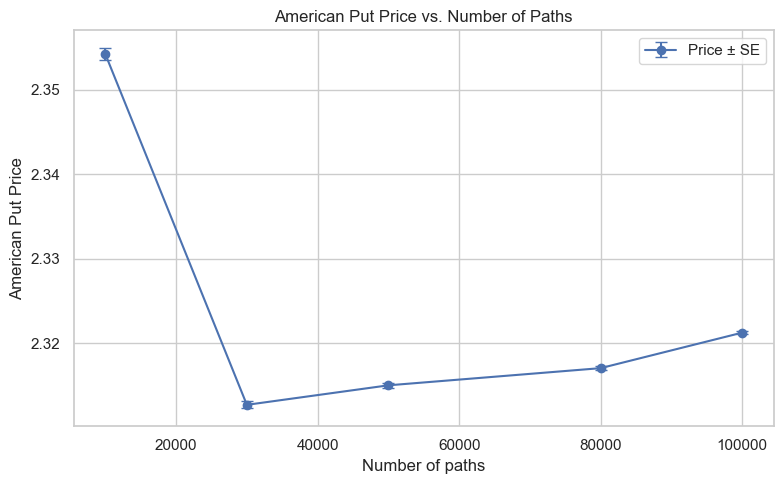

In [18]:
sns.set(style="whitegrid")


# Plot 1: Price ± SE vs Polynomial Degree (Laguerre)
plt.figure(figsize=(8, 5))
plt.errorbar(
    degrees,
    laguerre_prices,
    yerr=std_errors["Laguerre"],
    fmt='-o',
    capsize=4,
    label="Price ± SE",
    color="royalblue"
)
plt.xlabel("Polynomial Degree")
plt.ylabel("American Put Price")
plt.title("LSM Price vs. Polynomial Degree (Laguerre)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Standard Error vs Polynomial Degree (Laguerre)
plt.figure(figsize=(8, 5))
plt.plot(degrees, std_errors["Laguerre"], marker='o', linestyle='-', color='darkorange')
plt.xlabel("Polynomial Degree")
plt.ylabel("Standard Error")
plt.title("Standard Error vs. Polynomial Degree (Laguerre)")
plt.tight_layout()
plt.show()

# Plot 3: American Put Price vs Number of Time Steps
n_steps_list = [200, 100, 50, 25, 10]
prices_vs_dt = []

for new_n_steps in n_steps_list:
    pricer = AmericanPricer(spot_price, expiry, vanilla_american_payoff, rf)
    price, _, _ = pricer.get_lsm_price(paths, new_n_steps, get_laguerre_feature_funcs(3))
    prices_vs_dt.append(price)

sorted_pairs = sorted(zip(n_steps_list, prices_vs_dt))
n_steps_sorted, prices_sorted = zip(*sorted_pairs)

plt.figure(figsize=(8, 5))
plt.plot(n_steps_sorted, prices_sorted, '-o', label="Price")
plt.xlabel("Number of time steps")
plt.ylabel("American Put Price")
plt.title("American Put Price vs. Number of Time Steps")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: American Put Price ± SE vs Number of Paths
path_counts = [10000, 30000, 50000, 80000, 100000]
prices_by_paths = []
errors_by_paths = []

for count in path_counts:
    subset = paths[:count]
    pricer = AmericanPricer(spot_price, expiry, vanilla_american_payoff, rf)
    price, _, std_error = pricer.get_lsm_price(subset, n_steps, get_laguerre_feature_funcs(3))
    prices_by_paths.append(price)
    errors_by_paths.append(std_error)

plt.figure(figsize=(8, 5))
plt.errorbar(path_counts, prices_by_paths, yerr=errors_by_paths, fmt='-o', capsize=4, label="Price ± SE")
plt.xlabel("Number of paths")
plt.ylabel("American Put Price")
plt.title("American Put Price vs. Number of Paths")
plt.legend()
plt.tight_layout()
plt.show()


## Simulation with Jump Diffusion, Merton (1976)

Merton (1976) extends the Black-Scholes model by adding jumps to the asset price dynamics. The model is given by:

$$
dS_t = S_t\left[(\mu - \lambda \kappa)\,dt + \sigma\,dW_t + (J - 1)\,dN_t\right]
$$

Here, $W_t$ is standard Brownian motion, $N_t$ is a Poisson process with intensity $\lambda$, and $J$ is the random jump size. The term $\kappa = \mathbb{E}[J - 1]$ adjusts the drift to preserve the no-arbitrage condition.

In our implementation, we set $\lambda = 0.1$ and $\sigma_J = 0.2$. This implies that each simulated asset path has a 10% expected chance of experiencing a jump within the one-year horizon. These values are commonly used in the literature as conservative estimates, reflecting rare but moderate price shocks, and are consistent with empirical observations in equity markets.


In [10]:
def get_jump_diffusion_paths_antithetic(
    spot_price: float,
    expiry: float,
    num_paths: int,
    n_steps: int,
    r: float,
    sigma: float,
    lambda_jump: float = 0.1,
    sigma_j: float = 0.2,
    seed: int = 2025
) -> np.ndarray:
    if num_paths % 2 != 0:
        raise ValueError("num_paths must be even for antithetic simulation.")

    np.random.seed(seed)
    dt = expiry / n_steps
    paths = np.empty((num_paths, n_steps + 1))

    half_paths = num_paths // 2
    mu_j = -0.5 * sigma_j**2
    variance_correction = lambda_jump * (sigma_j**2 + mu_j**2)
    sigma_diff = np.sqrt(sigma**2 - variance_correction)

    for i in range(half_paths):
        for path_index, z in zip([2*i, 2*i + 1], [1, -1]):
            paths[path_index, 0] = spot_price

            for t in range(n_steps):
                current_price = paths[path_index, t]

                # Diffusion
                delta_w = z * np.random.normal(0, np.sqrt(dt))
                drift = (r - 0.5 * sigma_diff**2) * dt
                diffusion = sigma_diff * delta_w

                # Jump component
                n_jumps = np.random.poisson(lambda_jump * dt)
                jump_component = 0.0
                if n_jumps > 0:
                    jump_sizes = np.random.normal(mu_j, sigma_j, n_jumps)
                    jump_component = np.sum(jump_sizes)

                log_price = np.log(current_price) + drift + diffusion + jump_component
                paths[path_index, t + 1] = np.exp(log_price)

    return paths


In [11]:
paths_jump = get_jump_diffusion_paths_antithetic(
    spot_price=spot_price,
    expiry=expiry,
    num_paths=num_paths,
    n_steps=n_steps,
    r=rf,
    sigma=sigma,
    lambda_jump=0.1,
    sigma_j=0.2,
    seed=2025
)


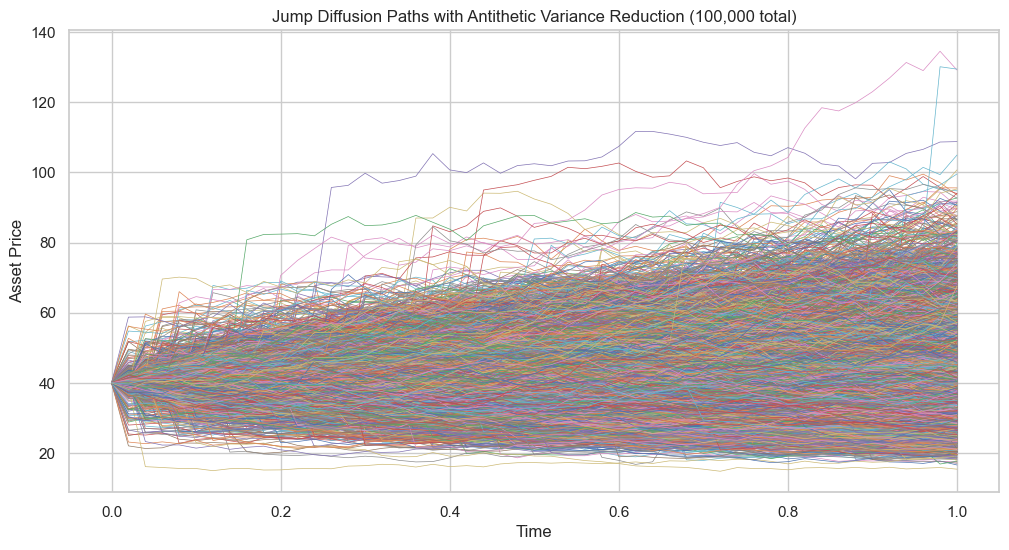

In [12]:
plt.figure(figsize=(12, 6))
for i in range(paths_jump.shape[0]):
    plt.plot(np.linspace(0, expiry, n_steps + 1), paths_jump[i], linewidth=0.5)

plt.title("Jump Diffusion Paths with Antithetic Variance Reduction (100,000 total)")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()


LSM took 10.12 seconds.
Laguerre degree 1: price = 2.4469, std_error = 0.0004
LSM took 13.08 seconds.
Laguerre degree 2: price = 2.4790, std_error = 0.0003
LSM took 16.99 seconds.
Laguerre degree 3: price = 2.4867, std_error = 0.0003
LSM took 21.51 seconds.
Laguerre degree 4: price = 2.4870, std_error = 0.0003
LSM took 27.58 seconds.
Laguerre degree 5: price = 2.4878, std_error = 0.0003


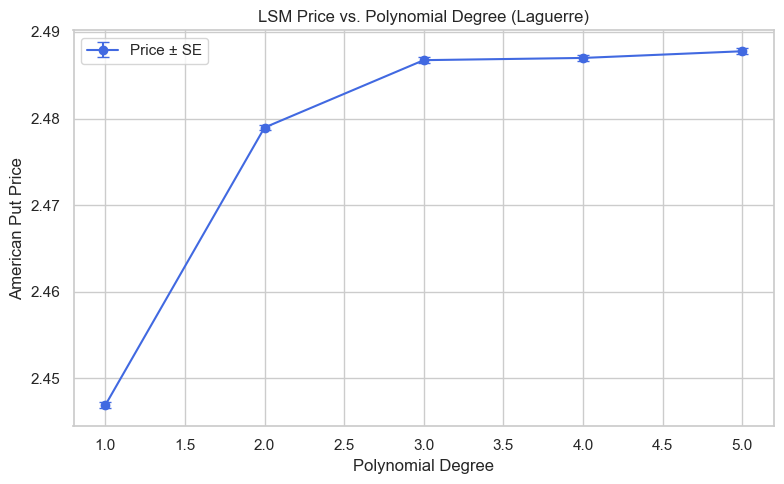

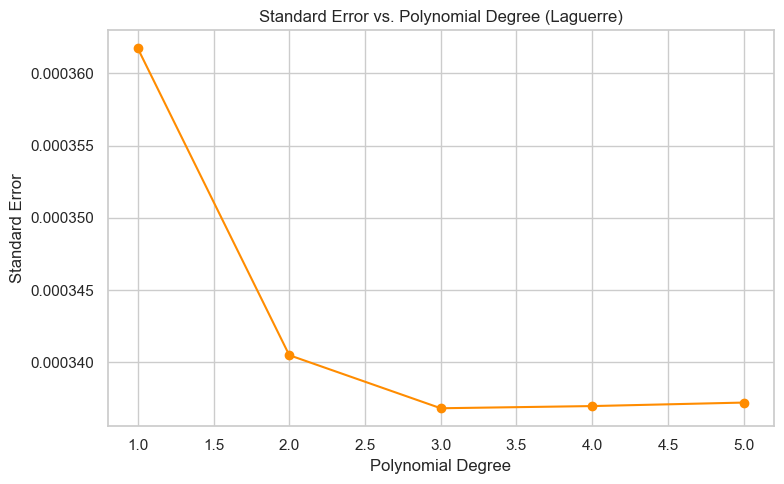

In [13]:
#Clear previous results
laguerre_prices = []
std_errors["Laguerre"] = []

degrees = list(range(1, 6))

def vanilla_american_payoff(_: float, x: np.ndarray) -> float:
    return max(1 - x[-1], 0.0)

paths_jump_normalized = paths_jump / strike

for deg in degrees:
    feature_funcs = get_laguerre_feature_funcs(deg)

    pricer = AmericanPricer(
        spot_price=spot_price,
        expiry=expiry,
        payoff=vanilla_american_payoff,
        r=rf
    )

    price, _, std_error = pricer.get_lsm_price(
        paths=paths_jump_normalized,
        num_dt=n_steps,
        feature_funcs=feature_funcs
    )

    laguerre_prices.append(price)
    std_errors["Laguerre"].append(std_error)

    print(f"Laguerre degree {deg}: price = {price:.4f}, std_error = {std_error:.4f}")

# Price ± Standard Error
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
plt.errorbar(
    degrees,
    laguerre_prices,
    yerr=std_errors["Laguerre"],
    fmt='-o',
    capsize=4,
    label="Price ± SE",
    color="royalblue"
)
plt.xlabel("Polynomial Degree")
plt.ylabel("American Put Price")
plt.title("LSM Price vs. Polynomial Degree (Laguerre)")
plt.legend()
plt.tight_layout()
plt.show()

# Standard Error
plt.figure(figsize=(8, 5))
plt.plot(degrees, std_errors["Laguerre"], marker='o', linestyle='-', color='darkorange')
plt.xlabel("Polynomial Degree")
plt.ylabel("Standard Error")
plt.title("Standard Error vs. Polynomial Degree (Laguerre)")
plt.tight_layout()
plt.show()


## Quasi-Monte Carlo

Quasi-Monte Carlo is a numerical integration and simulation method that replaces random sampling (as in standard Monte Carlo) with low-discrepancy sequences, with in this case is Sobol sequences. These deterministic sequences fill the space more uniformly, often resulting in faster convergence and lower variance in estimates. Unlike standard Monte Carlo, QMC is not stochastic, but scrambling techniques can be applied to introduce randomness and improve robustness.

In [14]:
num_paths = 100_000 
dt = expiry / n_steps

sobol_engine = Sobol(d=n_steps, scramble=True)
U = sobol_engine.random(n=num_paths)
Z_quasi = norm.ppf(U) 

log_returns = (rf - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_quasi
log_paths = np.cumsum(log_returns, axis=1)
log_paths = np.concatenate([np.zeros((num_paths, 1)), log_paths], axis=1)
paths_quasi = spot_price * np.exp(log_paths)
paths_quasi = paths_quasi / strike


c:\Users\rapas\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


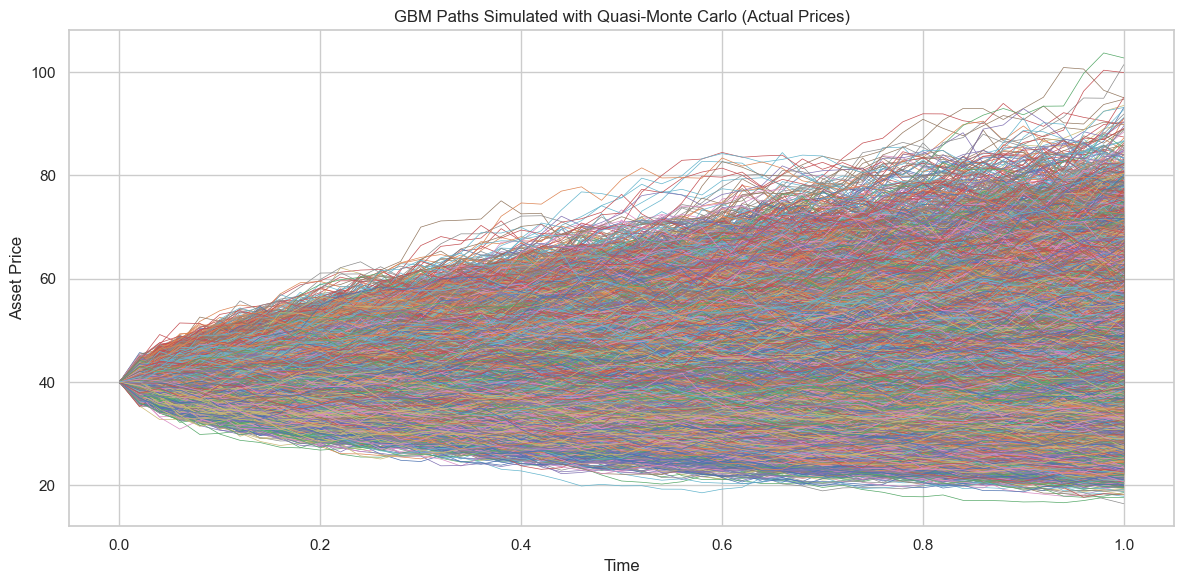

In [15]:
plt.figure(figsize=(12, 6))

paths_quasi_actual = paths_quasi * strike

for i in range(100000):
    plt.plot(np.linspace(0, expiry, n_steps + 1), paths_quasi_actual[i], linewidth=0.5)

plt.title("GBM Paths Simulated with Quasi-Monte Carlo (Actual Prices)")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True)
plt.tight_layout()
plt.show()


LSM took 20.64 seconds.
[QUASI] Laguerre degree 1: price = 2.4888, std_error = 0.0002
LSM took 25.32 seconds.
[QUASI] Laguerre degree 2: price = 2.5233, std_error = 0.0002
LSM took 33.37 seconds.
[QUASI] Laguerre degree 3: price = 2.5276, std_error = 0.0002
LSM took 42.78 seconds.
[QUASI] Laguerre degree 4: price = 2.5277, std_error = 0.0002
LSM took 54.27 seconds.
[QUASI] Laguerre degree 5: price = 2.5277, std_error = 0.0002


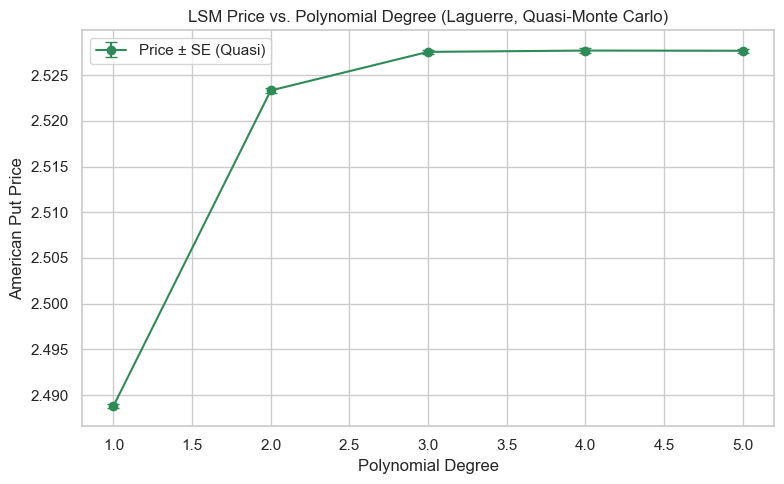

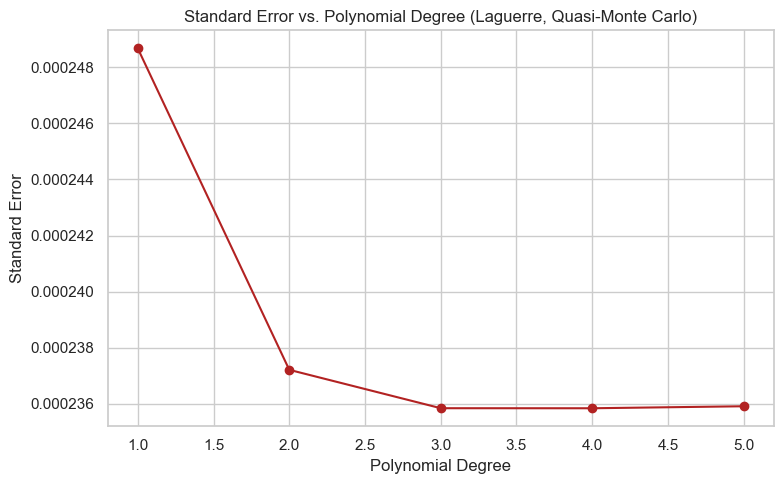

In [16]:
# Clear previous results if any
laguerre_prices_quasi = []
std_errors["Laguerre_Quasi"] = []

#Pricing
degrees = list(range(1, 6))


def vanilla_american_payoff(_: float, x: np.ndarray) -> float:
    return max(1 - x[-1], 0.0)


for deg in degrees:
    feature_funcs = get_laguerre_feature_funcs(deg)

    pricer = AmericanPricer(
        spot_price=spot_price,
        expiry=expiry,
        payoff=vanilla_american_payoff,
        r=rf
    )

    price, _, std_error = pricer.get_lsm_price(
        paths=paths_quasi,
        num_dt=n_steps,
        feature_funcs=feature_funcs
    )

    laguerre_prices_quasi.append(price)
    std_errors["Laguerre_Quasi"].append(std_error)

    print(f"[QUASI] Laguerre degree {deg}: price = {price:.4f}, std_error = {std_error:.4f}")

# Price ± Standard Error
plt.figure(figsize=(8, 5))
plt.errorbar(
    degrees,
    laguerre_prices_quasi,
    yerr=std_errors["Laguerre_Quasi"],
    fmt='-o',
    capsize=4,
    label="Price ± SE (Quasi)",
    color="seagreen"
)
plt.xlabel("Polynomial Degree")
plt.ylabel("American Put Price")
plt.title("LSM Price vs. Polynomial Degree (Laguerre, Quasi-Monte Carlo)")
plt.legend()
plt.tight_layout()
plt.show()

# Standard Error 
plt.figure(figsize=(8, 5))
plt.plot(degrees, std_errors["Laguerre_Quasi"], marker='o', linestyle='-', color='firebrick')
plt.xlabel("Polynomial Degree")
plt.ylabel("Standard Error")
plt.title("Standard Error vs. Polynomial Degree (Laguerre, Quasi-Monte Carlo)")
plt.tight_layout()
plt.show()
